<h1><center> 
    Neural network design and application
</center></h1>

<h2><center>CPT_S 434/534, 2022 Spring</center></h2>

<h2><center>HW 4: RNNs (100 pts)</center></h2>

### Name: *[INPUT YOUR NAME HERE]*

## This assignment includes:

## Coding in Python (PyTorch) and answering questions: train RNNs (100 points)

Step 0: Install and configure: python ([Anaconda platform](https://docs.anaconda.com/anaconda/install/) recommended), [Jupyter Notebook](https://jupyter.org/install) and [pytorch](https://pytorch.org/get-started/) 

**Remark 1.** [Colab](https://colab.research.google.com) is a cloud platform that enables your Jupyter Notebooks (including this .ipynb assignment) to run with different runtime types (hardware acceleration is possible using GPU or TPU). You may also choose Colab to finish assignments (future and this assignments may require extensive computation that may be time-consuming on your laptop). 

**Remark 2.** If you use Colab, it is still required to convert your .ipynb to .html and submit **BOTH** files to Canvas. See [this page](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) on how to convert to .html

Step 1: Read provided code (with pytorch) to understand the implementation logic of RNN/LSTM models, so that you know how to implement in the following step and how to re-use the provided code

Step 2: Complete the code of RNNs with different architectures on H. G. Wells’ *The Time Machine*

Step 3: Record and plot results to show performance measure convergence (against #epoch), excpet the section where other instructions are present for how to show results 

## Submission:

* Convert the .ipynb file to .html file (**save the execution outputs** to show your progress: otherwise grading may be affected)
    
* Upload **both** your .ipynb and .html files to Canvas (**NOT a .ZIP file**)

* Deadline: April 3, 11:59 PM, Pacific time.

* Plots should be clear and easy to read.


## Reference
* RNN codes are mostly copied from [Dive into Deep Learning](https://d2l.ai/index.html), section [8.5](https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html), [8.6](https://d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html), [9.2](https://d2l.ai/chapter_recurrent-modern/lstm.html)



# 1. (Read and run the code) Train Recurrent Neural Networks from Scratch

In this section we will implement an RNN
from scratch
for a character-level language model.
Such a model
will be trained on H. G. Wells' *The Time Machine*.
As before, we start by reading the dataset first.


In [ ]:
!pip install d2l==0.16.2
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, we initialize the model parameters for
the RNN model.
The number of hidden units `num_hiddens` is a tunable hyperparameter.
When training language models,
the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.


In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model,
we first need an `init_rnn_state` function
to return the hidden state at initialization.
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which we will encounter in later sections.


In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

The following `rnn` function defines how to compute the hidden state and output
at a time step.
Note that
the RNN model
loops through the outermost dimension of `inputs`
so that it updates hidden states `H` of a minibatch,
time step by time step.
Besides,
the activation function here uses the $\tanh$ function.
As
described in :numref:`sec_mlp`, the
mean value of the $\tanh$ function is 0, when the elements are uniformly
distributed over the real numbers.


In [7]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined,
next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.


In [8]:
class RNNModelScratch:  #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let us first define the prediction function
to generate new characters following
the user-provided `prefix`,
which is a string containing several characters.
When looping through these beginning characters in `prefix`,
we keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So we generate the predicted characters and emit them.


In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict_ch8` function.
We specify the prefix as `time traveller ` and have it generate 10 additional characters.
Given that we have not trained the network,
it will generate nonsensical predictions.


In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller w w w w w '

## Gradient Clipping

For a sequence of length $T$,
we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagation.
As mentioned in :numref:`sec_numerical_stability`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Generally speaking,
when solving an optimization problem,
we take update steps for the model parameter,
say in the vector form
$\mathbf{x}$,
in the direction of the negative gradient $\mathbf{g}$ on a minibatch.
For example,
with $\eta > 0$ as the learning rate,
in one iteration we update
$\mathbf{x}$
as $\mathbf{x} - \eta \mathbf{g}$.
Let us further assume that the objective function $f$
is well behaved, say, *Lipschitz continuous* with constant $L$.
That is to say,
for any $\mathbf{x}$ and $\mathbf{y}$ we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

In this case we can safely assume that if we update the parameter vector by $\eta \mathbf{g}$, then

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

which means that
we will not observe a change by more than $L \eta \|\mathbf{g}\|$. This is both a curse and a blessing.
On the curse side,
it limits the speed of making progress;
whereas on the blessing side,
it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$. But what if we only *rarely* get large gradients? In this case such an approach may appear entirely unwarranted. One popular alternative is to clip the gradient $\mathbf{g}$ by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction of $\mathbf{g}$.
It also has the desirable side-effect of limiting the influence any given
minibatch (and within it any given sample) can exert on the parameter vector. This
bestows a certain degree of robustness to the model. Gradient clipping provides
a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of
a model that is implemented from scratch or a model constructed by the high-level APIs.
Also note that we compute the gradient norm over all the model parameters.


In [12]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training


In [13]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports
an RNN model implemented
either from scratch
or using high-level APIs.


In [14]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train the RNN model.
Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.1, 90439.5 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


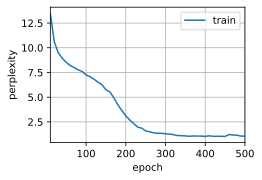

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally,
let us check the results of using the random sampling method.


perplexity 1.5, 99459.7 tokens/sec on cuda:0
time travellerit s against reason said filby of course a solid b
travellerit s against reason said filby of course a solid b


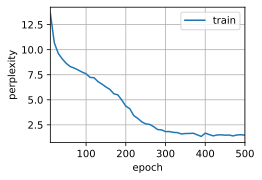

In [16]:
net2 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net2, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 2. Implementation (40 pts) and answer the question (10 pts): Tuning theta (the second input) of grad_clipping from values \{0.1, 10\} respectively and re-train the RNN (each value is worth 20 pts). 

perplexity 1.4, 105590.9 tokens/sec on cuda:0
time travellerit s against reason said filby hal glithes iat i s
travellerit s against reason said filby hal glithes iat i s


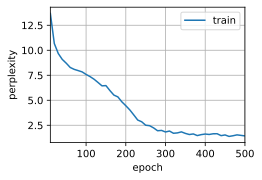

In [18]:
# Your code goes here
# Redefine the epoch function
def train_epoch_ch8_th01(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 0.1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 0.1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

newNet = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(newNet, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)


perplexity 1.4, 96807.3 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller after the pauserequired for the proper assimilati


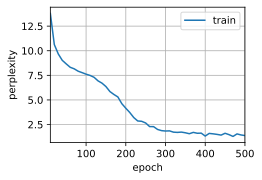

In [19]:

def train_epoch_ch8_th01(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 10)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 10)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

newNet = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
            init_rnn_state, rnn)
train_ch8(newNet, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## Question (10 pts): Summarize the key steps of the character-level language model implemented in this section

Answer: (Hint: one way is to follow the subtitles in [8.5](https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html) as key steps)

1. one-hot encoding to change position index i to 0's and 1's
2. Build the RNN model
3. Train
4. Gradient clipping while training
5. Predict

# 3. (Read, run the code and answer the questions at the end, 10 pts each question, 20 pts in total) Concise Implementation of Recurrent Neural Networks



In [ ]:
!pip install d2l==0.16.2
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## Defining the Model

High-level APIs provide implementations of recurrent neural networks.
We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units.
In fact, we have not even discussed yet what it means to have multiple layers---this will happen in :numref:`sec_deep_rnn`.
For now, suffice it to say that multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.


In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

We use a tensor to initialize the hidden state,
whose shape is
(number of hidden layers, batch size, number of hidden units).


In [4]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

With a hidden state and an input,
we can compute the output with
the updated hidden state.
It should be emphasized that
the "output" (`Y`) of `rnn_layer`
does *not* involve computation of output layers:
it refers to
the hidden state at *each* time step,
and they can be used as the input
to the subsequent output layer.


In [5]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Similar to :numref:`sec_rnn_scratch`,
we define an `RNNModel` class
for a complete RNN model.
Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer.


In [6]:
#@save
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

## Training and Predicting

Before training the model, let us make a prediction with the a model that has random weights.


In [7]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellersz s szs s'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyperparameters defined in :numref:`sec_rnn_scratch` and train our model with high-level APIs.


perplexity 1.3, 307182.1 tokens/sec on cuda:0
time traveller briccent the erassest has he thame hrer amt the e
travelleryou cantsatolland trevel in his tanalithry waid hi


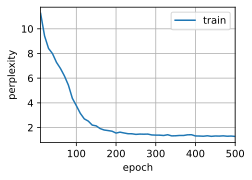

In [8]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

## Question 1 (10 pts): Summarize the key steps of the character-level language model implemented in this section
    

Answer: 
1. Build RNN model with high level API
2. Same old train and predict


## Question 2 (10 pts): Compare the difference between implementations of section 1 and 2. Which one would you prefer? 

You may read this [document for nn.rnn](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Answer:

Method 2 is better because:
1. The output doesn't not involve layer computation
2. Faster training than build model from scratch

# 4. (Read/run/implement code, 30 pts) Long Short-Term Memory (LSTM)

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

Next we need to define and initialize the model parameters. As previously, the hyperparameter `num_hiddens` defines the number of hidden units. We initialize weights following a Gaussian distribution with 0.01 standard deviation, and we set the biases to 0.


In [10]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Defining the Model

In the initialization function, the hidden state of the LSTM needs to return an *additional* memory cell with a value of 0 and a shape of (batch size, number of hidden units). Hence we get the following state initialization.


In [11]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

The actual model is defined just like what we discussed before: providing three gates and an auxiliary memory cell. Note that only the hidden state is passed to the output layer. The memory cell $\mathbf{C}_t$ does not directly participate in the output computation.


In [12]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### Training and Prediction

Let us train an LSTM as same as what we did in :numref:`sec_gru`, by instantiating the `RNNModelScratch` class as introduced in :numref:`sec_rnn_scratch`.


perplexity 1.1, 30282.3 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller beceedingencefilid efcerted the mudical man there


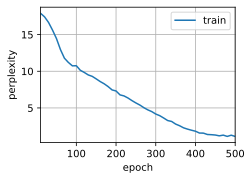

In [13]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

Using high-level APIs,
we can directly instantiate an `LSTM` model.
This encapsulates all the configuration details that we made explicit above. The code is significantly faster as it uses compiled operators rather than Python for many details that we spelled out in detail before.


perplexity 1.0, 334916.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


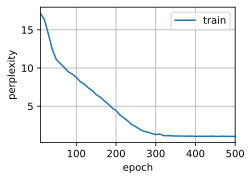

In [14]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## (To finish, 30 pts) Implement multiple (i.e., larger than or equal to 2) layers at a single LSTM unit

You may need to read [section 9.3.2](https://d2l.ai/chapter_recurrent-modern/deep-rnn.html) or take a look at [this document for nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
(You may fix or change other parameters)

perplexity 1.0, 206879.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


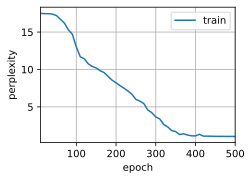

In [16]:
# Your code goes here
# Hint: the third input argument of nn.LSTM takes the number of stacked LSTM layers (defaut value is 1), 
# so we can simply specify another value larger than or equal to 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, 2)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)